## Score Based Learning

In this notebook I will explain the process of building a Bayesian network with a score based algorithm. Bayesian networks are very powerfull and very used in the industry. The problem is that this are very expensive to build since they are super exponential, at least in the example that pertains to this notebook.

First of all we need to identify the libraries we need and import them. This are all needed in orther get a complety view of the results, check the report for help in installing pygraphviz.


*   Pomegranate
*   Networkx
*   Pygraphviz
*   Sklearn
*   Numpy
*   matplotlib
*   seaborn








In [84]:
#Bayesian Networks
import pomegranate
from pomegranate import BayesianNetwork
#Utils
import seaborn, time
import numpy as np
import matplotlib.pyplot as plt
#Data
from sklearn.datasets import load_digits
from sklearn.datasets import load_breast_cancer
#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2
#Accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import random
import networkx
from pomegranate.utils import plot_networkx

seaborn.set_style('whitegrid')

# Data

For this particular example i decided to use the breast cancer data from sklearn, since is the one that is easier to interpret. In order to make this a quick example we will set the number of features we take to 4 as the standerd.

In [85]:
data= load_breast_cancer()
cancer_data, target = load_breast_cancer(return_X_y = True)
numVar = 4


print("Data shape: ",cancer_data.shape)
print("Class target shape: ",target.shape)
data["DESCR"]

Data shape:  (569, 30)
Class target shape:  (569,)


'.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry\n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        worst/largest values) of these features were computed for each image,\n        resulting in 30 features.  For inst

# Preprocessing

Our data is compossed of discrete numerical values, wich as i explained in the documentation is a 'no go' for any probabilistic aproach. In order to go around this we will change the values in the following way. For each feature we will calculate the mean and for every particular instance of that feature we will give it a true or false value based on if its value is higher or lower than the mean. Since the class is already binary the only modification we will make to it is a reshape in order to match the cancer_data shape. In the future we will need to convine them so this is important.

In [86]:
for i in range( cancer_data.shape[1]):
    cancer_data[:,i] =cancer_data[:,i] > np.mean(cancer_data[:,i])
    
target = np.reshape(target,(target.shape[0],1))

print("Class target shape: ",target.shape)
cancer_data

Class target shape:  (569, 1)


array([[1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

## Feature Selection

This networks are crazy time consuming scaling super-exponetially when we increse the numver of variables or the numver of values one takes, so doing good feature selection is important. In order to do this we need to use our feature selection algorithm after we make the conversion to True/False values. In this case i am using the SelectKBest algorithm from sklearn with chi2, others have shown similar results.

In [87]:
fSelector = SelectKBest(chi2, k= numVar)
selected_data = fSelector.fit_transform(cancer_data,target)
print("Feature selected data shape: ",selected_data.shape)

Feature selected data shape:  (569, 4)


## Splitting Our Dataset

we are almost at the end of the preprocessing part. In order to traint and test our data we will need to split it in 2.

In [88]:
# We use even indices for train data
cancer_train_data = selected_data [0::2]
cancer_train_class = target[0::2]

# We use odd could indices for test data
cancer_test_data  = selected_data[1::2]
cancer_test_class = target[1::2]

cancer_train_data.shape

(285, 4)

## Apendixes

Bayesian networks work predicting missing values, so what better way of adding a missing value that the 'None' value from python. We will create an array full of Nones the shape of our class prediction data.

In [89]:
apendix = []
for i in range(cancer_test_class.shape[0]):
    apendix.append(None)
apendix = np.array(apendix).reshape(cancer_test_class.shape[0],1)
apendix.shape

(284, 1)

One other thing we have to do is we need to add our training class column to our train data so we can train our bayesian network. This way the 'Exact' algorithm can check how good at predictions is each possible graph. 

In [90]:
final_train_data = np.concatenate((cancer_train_data,cancer_train_class), axis=1)
final_train_data.shape

(285, 5)

# Bayesian Network

In this part we will build the Bayesian network train it and use it in order to make some predictions.

## Training

In order to train the Bayesian network with pomegranate we will need to give him data in any two dimensional array form with non-discrete values and every column should have standarized values in order to work. The class variable should also be included in the data. The oder parameter we need to specify is what algorithm we will use, if we want to build our Bayesian network we need to specify wich algorithm we want to use. In our case we want it build based upon a score based system, for this we have 2 options: 'excap-dp' and 'exact', we will use 'exact' since it's an A* algorithm making it faster and using less memory compared to it's counter part.

### Simple Implementation
In order to build a simple implementation we just need our data and to follow the instructions above.

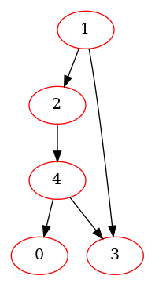

The models structure is:  ((4,), (), (1,), (1, 4), (2,))
Building the model took 0.11951041221618652 `s


In [91]:
t1 = time.time()
model = BayesianNetwork.from_samples(final_train_data, algorithm='exact') #A* algorithm for score based struture learning
plt.figure(figsize=(10, 5))
model.plot()
plt.show()
print("The models structure is: ", model.structure)
print("Building the model took", time.time() -t1, "`s")

### Constraint Graph version

Constraint graphs are usfull when you preciesly now the restrictions of the problem and want to accelerate the proccess, They are also usefull if you want to specify some constraints that cant be learnt from the data alone without context. If you have no information along this line i strongly reccomend staying away from them. In order to make this demonstraition I will use the previous 4 variable to learn restriction between themselfs and use this to build our constraint graph.

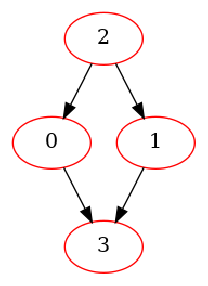

In [92]:
t1 = time.time()
model1 = BayesianNetwork.from_samples(cancer_train_data, algorithm='exact') #A* algorithm for score based struture learning
plt.figure(figsize=(6, 5))
model1.plot()
plt.show()
t2 = time.time()-t1

From the graph above we learn that variable 2 affects variable 0 and 1 and this last 2 affect variable 3. Now we need to tell the model that our class variables 4 is affected by all of them.

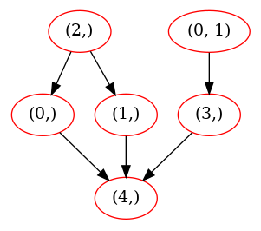

In [93]:
g = networkx.DiGraph()
b = tuple([numVar])
for i in range(len(model1.structure)):
    if len(model1.structure[i]) > 0:
        g.add_edge(model1.structure[i],tuple([i]))
        g.add_edge(tuple([i]),b)
#contraint graph
plot_networkx(g)
plt.show()

We will run the exact algorithm again but with our constraint graph. In this example since we have to get the graph with the algorithm and we have a low number of features it doesnt show and we are plotting more. If you want to see it in action load the graph from another source or let the numver of variables go hihger.

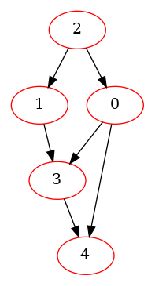

Building the model took 0.24510502815246582 `s


In [94]:
#We add the class to our training datas
t3 = time.time()
final_train_data = np.concatenate((cancer_train_data,cancer_train_class), axis=1)
model_cons = BayesianNetwork.from_samples(final_train_data, algorithm='exact',constraint_graph= g) #A* algorithm for score based struture learning
plt.figure(figsize=(5, 5))
model_cons.plot()
plt.show()
final_time = (time.time()-t3) +t2
print("Building the model took", final_time, "`s")

### Predicting

In order to predict we need to provide a matrix with as many rows as instances we want to predict, using None as the values to infer. 0s are Falses and 1s are Trues.

In [95]:
model_cons.predict([[None,True,True,False,None]])

[array([0.0, True, True, False, 1.0], dtype=object)]

# Validations

For the validation we will use our appendix in order to get a class full of Nones so the modell can predict them. After that we will need to extract the column where the class is stored since the prediction gives as an object with the matrix with all the predictions.

In [102]:
test = np.concatenate((cancer_test_data,apendix), axis=1)
res0 = model.predict( test )
res = model_cons.predict( test )
res

[array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 1.0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 1.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 1.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 0.0, 1.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 1.0], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 1.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0.0], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 1.0], dtype=object),
 array([1.0, 0.0, 1.0, 0.0, 1.0], dtype=object),
 array([1.0, 0.0, 0.

Extracting the class prediction.

In [103]:
#Predictions for the first model
predict0 = []
k = np.shape(res0)
for i in range(k[0]):
    predict0.append(res0[i][numVar])
predict0 = np.array(predict0).reshape(k[0],1)

#Predictions for the second model
predict = []
k = np.shape(res)
for i in range(k[0]):
    predict.append(res[i][numVar])
predict = np.array(predict).reshape(k[0],1)


## Results

Lets observer the results for our 2 models

In [105]:
#For the simple model we get this accuracy socre and confusion matrix
acc = accuracy_score(predict0, cancer_test_class)

confusionMTRX = confusion_matrix(cancer_test_class,predict0)
print("Accuracy score: ",acc)
print("Confusion Matrix")
print(confusionMTRX)


Accuracy score:  0.9084507042253521
Confusion Matrix
[[ 96  14]
 [ 12 162]]


In [106]:
#For the model with constraints we get this accuracy socre and confusion matrix
acc = accuracy_score(predict, cancer_test_class)

confusionMTRX = confusion_matrix(cancer_test_class,predict)
print("Accuracy score: ",acc)
print("Confusion Matrix")
print(confusionMTRX)


Accuracy score:  0.9049295774647887
Confusion Matrix
[[ 89  21]
 [  6 168]]


We can see that each one has a preference towards a certains class, given the subject is cancer I am favorable to the simple model since it is more accurate at correctly classifying malign tumors.